In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [2]:
pip install timm

Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import timm
from PIL import Image


In [7]:
# Directories for real and manipulated videos
real_videos_dir = "/kaggle/input/deep-fake-detection-dfd-entire-original-dataset/DFD_original sequences"
manipulated_videos_dir = "/kaggle/input/deep-fake-detection-dfd-entire-original-dataset/DFD_manipulated_sequences/DFD_manipulated_sequences"

# Output directories for extracted frames
output_real_dir = "/kaggle/working/frames/real"
output_manipulated_dir = "/kaggle/working/frames/manipulated"


In [8]:
# Ensure output directories exist
os.makedirs(output_real_dir, exist_ok=True)
os.makedirs(output_manipulated_dir, exist_ok=True)

In [10]:
def extract_frames_from_videos(videos_dir, output_dir, label, max_videos=50):
    video_files = [f for f in os.listdir(videos_dir) if f.endswith(('.mp4', '.avi', '.mov', '.mkv'))]
    video_files = video_files[:max_videos]  # Limit to max_videos

    for video_file in video_files:
        video_path = os.path.join(videos_dir, video_file)
        cap = cv2.VideoCapture(video_path)
        frame_count = 0
        success, image = cap.read()

        while success:
            if frame_count % int(cap.get(cv2.CAP_PROP_FPS)) == 0:
                frame_filename = f"{label}_{video_file}_frame{frame_count // int(cap.get(cv2.CAP_PROP_FPS))}.jpg"
                frame_path = os.path.join(output_dir, frame_filename)
                cv2.imwrite(frame_path, image)
            success, image = cap.read()
            frame_count += 1

        cap.release()

In [11]:
# Extract frames from 100 real and 100 manipulated videos
extract_frames_from_videos(real_videos_dir, output_real_dir, "real", max_videos=100)
extract_frames_from_videos(manipulated_videos_dir, output_manipulated_dir, "manipulated", max_videos=100)
print("Frame extraction completed.")


Frame extraction completed.


In [12]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define image transformations with advanced augmentations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [13]:
# Load the dataset
dataset_dir = "/kaggle/working/frames"  # Directory where frames are saved
dataset = datasets.ImageFolder(root=dataset_dir, transform=transform)

# Split dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)


In [15]:
pip install urllib3==1.26.20

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Load Vision Transformer (ViT) model
model = timm.create_model('vit_large_patch16_224', pretrained=True, num_classes=2)
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.7)

# Training loop with early stopping
num_epochs = 20
best_val_accuracy = 0
patience = 5
patience_counter = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Training Accuracy: {train_accuracy:.2f}%")

    # Validation
    model.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = 100 * correct_val / total_val
    print(f"Validation Accuracy: {val_accuracy:.2f}%")

    # Save best model with early stopping
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_vit_model.pth')
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping due to no improvement.")
            break
    scheduler.step()

print(f"Best Validation Accuracy: {best_val_accuracy:.2f}%")

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Epoch [1/20], Loss: 0.6866, Training Accuracy: 59.87%
Validation Accuracy: 60.24%
Epoch [2/20], Loss: 0.5893, Training Accuracy: 67.14%
Validation Accuracy: 68.96%
Epoch [3/20], Loss: 0.5553, Training Accuracy: 68.96%
Validation Accuracy: 71.09%
Epoch [4/20], Loss: 0.5052, Training Accuracy: 72.62%
Validation Accuracy: 73.41%
Epoch [5/20], Loss: 0.4842, Training Accuracy: 73.77%
Validation Accuracy: 74.85%
Epoch [6/20], Loss: 0.4425, Training Accuracy: 76.20%
Validation Accuracy: 76.09%
Epoch [7/20], Loss: 0.4279, Training Accuracy: 77.00%
Validation Accuracy: 77.05%


In [16]:
from sklearn.metrics import classification_report, accuracy_score

# Load the best model
model.load_state_dict(torch.load('best_vit_model.pth', weights_only=True))
model.eval()

all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Calculate classification metrics
print("Classification Report:")
print(classification_report(all_labels, all_predictions, target_names=['Real', 'Manipulated']))

# Optionally print accuracy separately
accuracy = accuracy_score(all_labels, all_predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")


Classification Report:
              precision    recall  f1-score   support

        Real       0.88      0.89      0.89       661
 Manipulated       0.90      0.89      0.90       721

    accuracy                           0.89      1382
   macro avg       0.89      0.89      0.89      1382
weighted avg       0.89      0.89      0.89      1382

Accuracy: 89.15%


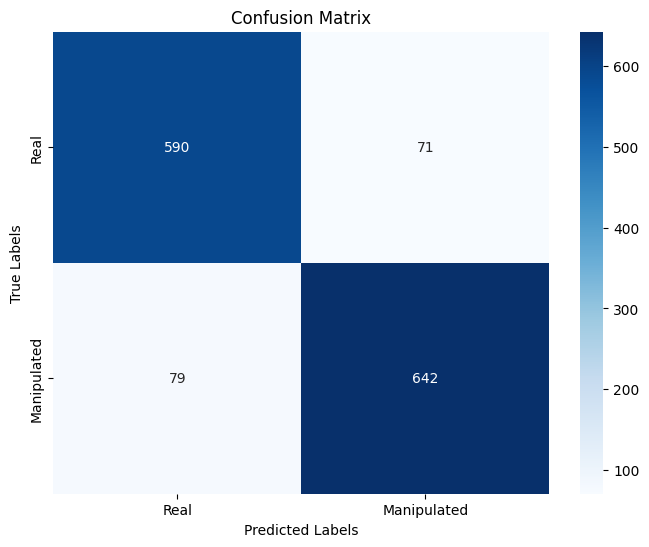

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Manipulated'], yticklabels=['Real', 'Manipulated'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [18]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import cv2
import timm

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define image transformations (same as used during training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the trained model
model = timm.create_model('vit_large_patch16_224', pretrained=False, num_classes=2)
# Load the trained model with weights_only=True for security
model.load_state_dict(torch.load('best_vit_model.pth', weights_only=True))
model.to(device)
model.eval()

# Function to process the video and classify each frame
def predict_video(video_path, model, transform, device):
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    real_count = 0
    manipulated_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        frame_count += 1

        # Convert frame to PIL Image and apply transformations
        image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        image = transform(image).unsqueeze(0).to(device)  # Add batch dimension

        # Make prediction
        with torch.no_grad():
            outputs = model(image)
            _, predicted = torch.max(outputs, 1)
        
        if predicted.item() == 0:
            real_count += 1
        else:
            manipulated_count += 1

    cap.release()

    # Final decision based on majority vote across all frames
    if real_count > manipulated_count:
        print(f"Result: Real video ({real_count} real frames, {manipulated_count} manipulated frames)")
        return "Real"
    else:
        print(f"Result: Manipulated video ({real_count} real frames, {manipulated_count} manipulated frames)")
        return "Manipulated"

# Test the video
video_path = "/kaggle/input/deep-fake-detection-dfd-entire-original-dataset/DFD_original sequences/02__kitchen_still.mp4"
result = predict_video(video_path, model, transform, device)


Result: Real video (855 real frames, 0 manipulated frames)


In [19]:
video_path = "/kaggle/input/deep-fake-detection-dfd-entire-original-dataset/DFD_manipulated_sequences/DFD_manipulated_sequences/01_20__walking_and_outside_surprised__OTGHOG4Z.mp4"
result = predict_video(video_path, model, transform, device)

Result: Manipulated video (0 real frames, 844 manipulated frames)


In [22]:
video_path = "/kaggle/input/deep-fake-detection-dfd-entire-original-dataset/DFD_original sequences/15__exit_phone_room.mp4"
result = predict_video(video_path, model, transform, device)

Result: Real video (405 real frames, 24 manipulated frames)


In [23]:
video_path = "/kaggle/input/deep-fake-detection-dfd-entire-original-dataset/DFD_manipulated_sequences/DFD_manipulated_sequences/01_20__walking_and_outside_surprised__OTGHOG4Z.mp4"
result = predict_video(video_path, model, transform, device)

Result: Manipulated video (0 real frames, 844 manipulated frames)


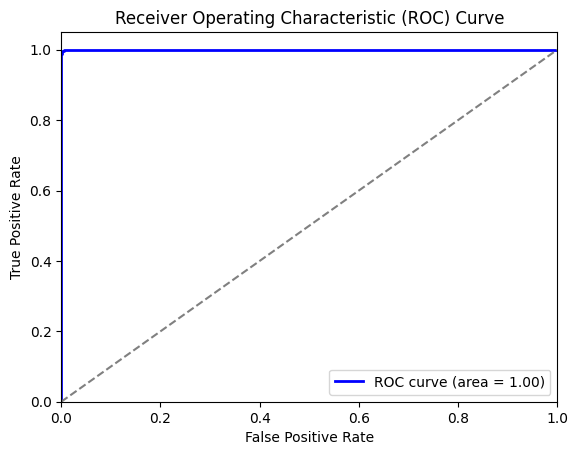

In [20]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from torchvision import transforms
from PIL import Image

# Function to get probabilities and true labels
def get_predictions_and_labels(video_paths, labels, model, transform, device):
    all_probs = []
    all_labels = []
    
    model.eval()
    with torch.no_grad():
        for video_path, label in zip(video_paths, labels):
            cap = cv2.VideoCapture(video_path)
            while cap.isOpened():
                ret, frame = cap.read()
                if not ret:
                    break
                
                # Convert frame to PIL Image and apply transformations
                image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
                image = transform(image).unsqueeze(0).to(device)  # Add batch dimension
                
                # Get model prediction probability
                outputs = model(image)
                probs = torch.nn.functional.softmax(outputs, dim=1)[:, 1]  # Probability of manipulated class
                
                all_probs.append(probs.cpu().numpy()[0])
                all_labels.append(label)
            cap.release()
    return np.array(all_probs), np.array(all_labels)

# Define video paths and labels (1 for manipulated, 0 for real)
video_paths = [
    "/kaggle/input/deep-fake-detection-dfd-entire-original-dataset/DFD_original sequences/02__kitchen_still.mp4",
    "/kaggle/input/deep-fake-detection-dfd-entire-original-dataset/DFD_manipulated_sequences/DFD_manipulated_sequences/01_20__walking_and_outside_surprised__OTGHOG4Z.mp4",
    "/kaggle/input/deep-fake-detection-dfd-entire-original-dataset/DFD_original sequences/15__exit_phone_room.mp4",
    "/kaggle/input/deep-fake-detection-dfd-entire-original-dataset/DFD_manipulated_sequences/DFD_manipulated_sequences/01_20__walking_and_outside_surprised__OTGHOG4Z.mp4"
]
labels = [0, 1, 0, 1]  # Corresponding labels

# Get probabilities and true labels
probs, true_labels = get_predictions_and_labels(video_paths, labels, model, transform, device)

# Compute ROC curve
fpr, tpr, _ = roc_curve(true_labels, probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

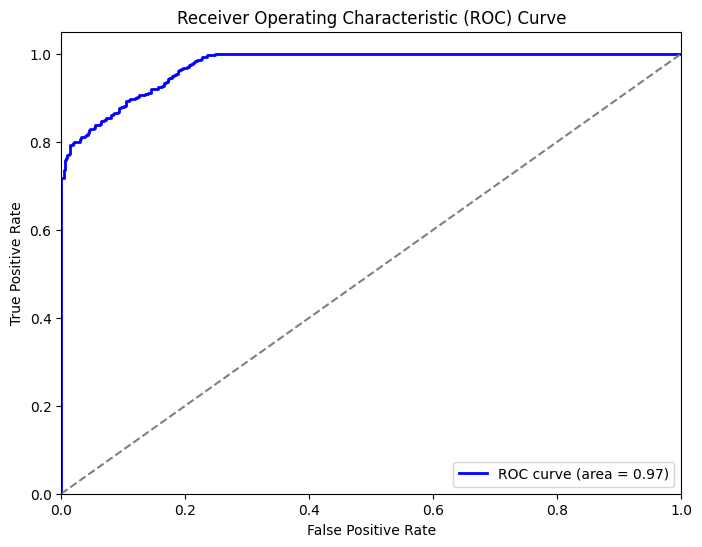

In [21]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Convert labels and predictions to tensors
all_labels = torch.tensor(all_labels)
all_predictions = torch.tensor(all_predictions)

# Get probability scores for positive class (manipulated videos)
with torch.no_grad():
    all_probs = []
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)[:, 1]  # Probability for class "Manipulated"
        all_probs.extend(probs.cpu().numpy())

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(all_labels.numpy(), all_probs)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
